# Mann-Whitney U-Test for Comparing Means:
> Use Case: 
- Compare distributions of two independent groups when assumptions for the t-test are not met.
> Assumptions:
- Data is at the ordinal scale or approximately so.
- Observations are independent.
> Example Scenario:
- Assessing if there is a significant difference in the rankings of satisfaction levels between two product groups.
> Null Hypothesis (H0):
- There is no significant difference in the distributions of the two groups.
> Alternative Hypothesis (H1):
- There is a significant difference in the distributions of the two groups.

In [47]:
import warnings

warnings.filterwarnings("ignore")

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import statsmodels.stats.power as smp

# !pip install scipy==1.12.0
from scipy.stats import shapiro, mannwhitneyu

# !pip install pingouin==0.5.4
import pingouin as pg

In [49]:
# Set random seed for reproducibility
np.random.seed(42)

In [83]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'mediumpurple'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [84]:


def calculate_mann_whitney_sample_size(effect_size, alpha=0.05, power=0.8, ratio=1.0, alternative='two-sided'):
    """
    Calculates the approximate sample size needed per group for a Mann-Whitney U-test using the normal approximation.

    Note: This is an approximation and might not be perfectly accurate, especially for small sample sizes or when distributions are very different.
            More precise methods often involve simulations.
    Args:
        effect_size (float): A standardized effect size measure. Cohen's d is often used as a proxy here, though it's technically for parametric tests.
                            A rough guideline: small=0.2, medium=0.5, large=0.8.
        alpha (float, optional): Significance level (Type I error rate). Defaults to 0.05.
        power (float, optional): Desired power of the test (1 - Type II error rate). Defaults to 0.8.
        ratio (float, optional): Ratio of the sample size of the second group to the first group (n2/n1). Defaults to 1.0 (equal sample sizes).
        alternative (str, optional): 'two-sided' or 'one-sided'. Defaults to 'two-sided'.

    Returns:
        int: The approximate sample size needed per group (for the first group). 
             The sample size for the second group will be approximately `ratio * sample_size_group1`.
                Returns None if the power analysis fails.
    """

    if alternative not in ['two-sided', 'one-sided']:
        raise ValueError("Alternative must be 'two-sided' or 'one-sided'")

    analysis = smp.TTestIndPower()
    n1 = analysis.solve_power(effect_size=effect_size,
                                alpha=alpha,
                                power=power,
                                ratio=ratio,
                                nobs1=None,
                                alternative=alternative)

    if n1 is not None:
        return int(np.ceil(n1))
    else:
        return None

In [85]:
alpha_level = 0.05
desired_power = 0.8
sample_ratio = 1.0 # Equal sample sizes 

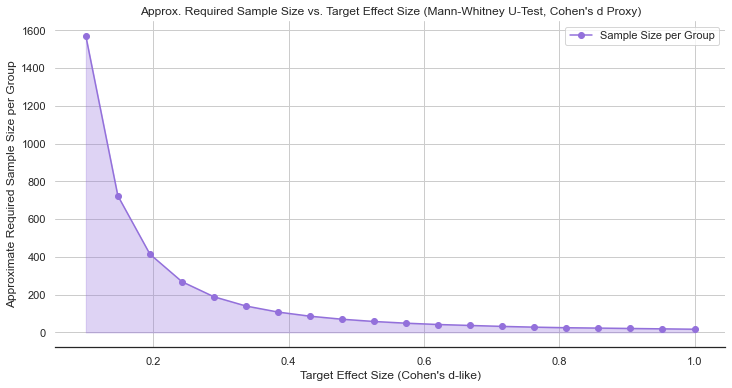

In [86]:
# Define a range of effect sizes to explore
effect_sizes = np.linspace(0.1, 1.0, 20) # From small to large effect sizes

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for effect in effect_sizes:
    n = calculate_mann_whitney_sample_size(
        effect_size=effect,
        alpha=alpha_level,
        power=desired_power,
        ratio=sample_ratio
    )
    if n is not None:
        sample_sizes.append(n)
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Approx. Required Sample Size vs. Target Effect Size (Mann-Whitney U-Test, Cohen\'s d Proxy)')
plt.xlabel('Target Effect Size (Cohen\'s d-like)')
plt.ylabel('Approximate Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [87]:
# Let's say we anticipate a small effect size (Cohen's d = 0.2)
effect = 0.2

sample_size_per_group = calculate_mann_whitney_sample_size(
    effect_size=effect,
    alpha=alpha_level,
    power=desired_power,
    ratio=sample_ratio
)

if sample_size_per_group:
    print(f"Approximate sample size needed per group: {sample_size_per_group}")
    if sample_ratio != 1.0:
        sample_size_group2 = int(np.ceil(sample_size_per_group * sample_ratio))
        print(f"Approximate sample size needed for group 2: {sample_size_group2}")
    else:
        sample_size_group2 = sample_size_per_group
else:
    print("Could not calculate sample size.")
    

Approximate sample size needed per group: 394


### Synthetic Data

In [104]:

# Define the possible scores and their weights
scores_group_a = [1, 2, 3, 4]
weights_group_a = [0.4, 0.3, 0.2, 0.1]  # Example weights, should sum to 1

scores_group_b = [1, 2, 3, 4]
weights_group_b = [0.1, 0.2, 0.4, 0.3]  # Example weights, should sum to 1

# Generate synthetic data for Group A based on weighted probabilities
group_a_ranked = np.random.choice(scores_group_a, size=sample_size_per_group, p=weights_group_a)

# Generate synthetic data for Group B based on weighted probabilities
group_b_ranked = np.random.choice(scores_group_b, size=sample_size_group2, p=weights_group_b)

# Create pandas DataFrame
mann_whitney_data = pd.DataFrame({'Group A Ranked': group_a_ranked, 'Group B Ranked': group_b_ranked})
mann_whitney_data


,Group A Ranked,Group B Ranked
0,2,3
1,1,3
2,3,4
3,3,3
4,2,2
...,...,...
389,2,4
390,1,1
391,2,3
392,3,3


### Assumptions

In [105]:
# Assumption validation for Mann-Whitney U-test
def validate_mann_whitney_assumptions(data, alpha=0.05):
    # Shapiro-Wilk test for normality - Group A
    stat_a, p_value_a = shapiro(data['Group A Ranked'])
    print(f'Mann-Whitney U-Test (Group A Non-Normality): Statistic={stat_a}, p-value={p_value_a}')
    
    # Interpretation based on p-value for Group A
    if p_value_a < alpha:
        print(f'Reject the null hypothesis for Group A: \nData is not normally distributed.')
    else:
        print(f'Fail to reject the null hypothesis for Group A: \nData is approximately normally distributed.')

    # Shapiro-Wilk test for normality - Group B
    stat_b, p_value_b = shapiro(data['Group B Ranked'])
    print(f'\nMann-Whitney U-Test (Group B Non-Normality): Statistic={stat_b}, p-value={p_value_b}')

    # Interpretation based on p-value for Group B
    if p_value_b < alpha:
        print(f'Reject the null hypothesis for Group B: \nData is not normally distributed.')
    else:
        print(f'Fail to reject the null hypothesis for Group B: \nData is approximately normally distributed.')

# Example usage for Mann-Whitney U-test data
validate_mann_whitney_assumptions(mann_whitney_data)

Mann-Whitney U-Test (Group A Non-Normality): Statistic=0.8132886970241657, p-value=5.025134627427676e-21
Reject the null hypothesis for Group A: 
Data is not normally distributed.

Mann-Whitney U-Test (Group B Non-Normality): Statistic=0.8597742668193182, p-value=2.470438214404975e-18
Reject the null hypothesis for Group B: 
Data is not normally distributed.


### Mann Whitney U-Test (SciPy)

In [106]:
# Function to run Mann-Whitney U-Test
def run_mann_whitney(data, alpha=0.05):
    stat, p_value = mannwhitneyu(data['Group A Ranked'], data['Group B Ranked'], alternative='two-sided')
    print(f'Mann-Whitney U-Test: Statistic={stat}, p-value={p_value}')

    # Interpretation based on p-value
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

# Example usage for Mann-Whitney U-test data
run_mann_whitney(mann_whitney_data)

Mann-Whitney U-Test: Statistic=40574.5, p-value=2.6322645846058898e-33

Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### Mann-Whitney U-test (pingouin)

In [107]:
def run_mann_whitney_u_test_pingouin(group_a, group_b, alpha=0.05):
    """
    Runs Mann-Whitney U-test using the pingouin package.

    Args:
        data (dict): A dictionary containing the data for 'Group A' and 'Group B'.
        alpha (float, optional): Significance level (default: 0.05).

    Returns:
        pandas.DataFrame: DataFrame containing the results of the Mann-Whitney U-test.
    """
    # Perform the Mann-Whitney U-test using pingouin
    results = pg.mwu(group_a, group_b, alternative='two-sided')
    print("Mann-Whitney U-test Results:")
    display(results)

    # Interpretation based on the p-value from the pingouin output
    p_value = results['p-val'].iloc[0]
    if p_value < alpha:
        print(f'\nReject the null hypothesis: \nThere is a significant difference between Group A and Group B.')
    else:
        print(f'\nFail to reject the null hypothesis: \nThere is no significant difference between Group A and Group B.')

    return results


In [108]:
# Example usage for Mann-Whitney U-test data
results_pingouin = run_mann_whitney_u_test_pingouin(mann_whitney_data['Group A Ranked'], mann_whitney_data['Group B Ranked'])

Mann-Whitney U-test Results:


,U-val,alternative,p-val,RBC,CLES
MWU,40574.5,two-sided,2.632265e-33,0.477254,0.261373



Reject the null hypothesis: 
There is a significant difference between Group A and Group B.


### Effect Size - Point Biserial Correlation

In [121]:

def rank_biserial_correlation(u, n1, n2):
    """Calculates the rank-biserial correlation (r) from the U statistic."""
    return 1 - (2 * u) / (n1 * n2)

# Assuming 'group_a_ranked' and 'group_b_ranked' are your data arrays
n1 = len(group_a_ranked)
n2 = len(group_b_ranked)
u, p = mannwhitneyu(group_a_ranked, group_b_ranked, alternative='two-sided')

r = rank_biserial_correlation(u, n1, n2)
print(f"Rank-Biserial Correlation (r): {r:.3f}")

# Interpretation (rough guidelines):
# |r| < 0.3: Small effect
# 0.3 <= |r| < 0.5: Medium effect
# |r| >= 0.5: Large effect

Rank-Biserial Correlation (r): 0.477


### Effect Size - CLES

In [122]:
def common_language_effect_size(group1, group2):
    """Calculates the Common Language Effect Size."""
    n1 = len(group1)
    n2 = len(group2)
    greater_than_count = 0
    ties_count = 0
    for x in group1:
        for y in group2:
            if x > y:
                greater_than_count += 1
            elif x == y:
                ties_count += 0.5
    return (greater_than_count + ties_count) / (n1 * n2)

cles = common_language_effect_size(group_a_ranked, group_b_ranked)
print(f"Common Language Effect Size (CLES): {cles:.3f}")

# Interpretation:
# Around 0.5: No effect
# 0.6 (or 0.4): Small effect
# 0.7 (or 0.3): Medium effect
# 0.8 (or 0.2): Large effect

Common Language Effect Size (CLES): 0.261


### Effect Size - Cohen's d Approximation

In [ ]:
n1 = len(group_a_ranked)
n2 = len(group_b_ranked)
u, p = mannwhitneyu(group_a_ranked, group_b_ranked, alternative='two-sided')

mean_u = n1 * n2 / 2
std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
z = (u - mean_u) / std_u

# Cohen's d approximation for Mann-Whitney U (R formula often used)
r_effect_size = abs(z) / np.sqrt(n1 + n2)
d_approx = r_effect_size * (2 * z) / np.sqrt(1 - (r_effect_size**2)) if (1 - (r_effect_size**2)) > 0 else np.nan # Approximation, use with caution

print(f"Standardized z-statistic: {z:.3f}")
print(f"Cohen's d-like effect size (approx.): {d_approx:.3f}")

# Interpretation of Cohen's d:
# |d| around 0.2: Small effect
# |d| around 0.5: Medium effect
# |d| around 0.8: Large effect

Standardized z-statistic: -11.595
Cohen's d-like effect size (approx.): -10.518


### Visualization

In [109]:
# Count everything up
total_count = mann_whitney_data.size
group_a_count = mann_whitney_data['Group A Ranked'].count()
group_b_count = mann_whitney_data['Group B Ranked'].count()
group_a_mean = mann_whitney_data['Group A Ranked'].mean()
group_b_mean = mann_whitney_data['Group B Ranked'].mean()
group_a_var= mann_whitney_data['Group A Ranked'].var()
group_b_var = mann_whitney_data['Group B Ranked'].var()
group_a_std= mann_whitney_data['Group A Ranked'].std()
group_b_std = mann_whitney_data['Group B Ranked'].std()

In [110]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Avg Satisfaction Score': [group_a_mean, group_b_mean],
    'Variance': [group_a_var, group_b_var],
    'Standard Deviation': [group_a_std, group_b_std],
}, index=[0, 1])
plot_data

,Test Group,Total,Avg Satisfaction Score,Variance,Standard Deviation
0,Group A,394,1.921320,0.942903,0.971032
1,Group B,394,2.824873,0.892917,0.944943


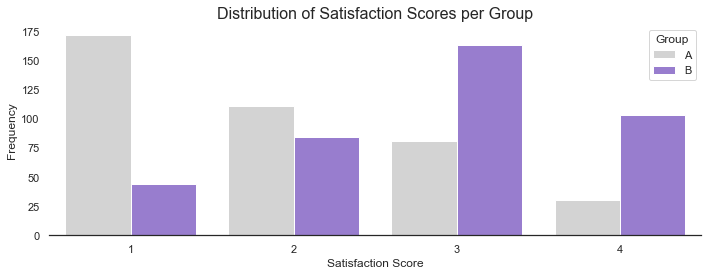

In [120]:
# Create pandas DataFrame
mann_whitney_data = pd.DataFrame({'Group': ['A'] * sample_size_per_group + ['B'] * sample_size_group2,
                                'Ranked Score': np.concatenate([group_a_ranked, group_b_ranked])})
# Create bar plots
plt.figure(figsize=(10, 4))
sns.countplot(data=mann_whitney_data, x='Ranked Score', hue='Group', palette={'A': 'lightgrey', 'B': color})
plt.title('Distribution of Satisfaction Scores per Group', fontsize=16)
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Group')
plt.tight_layout()
plt.show()